In [1]:
!pip install ofa
! pip install torchsummary
!pip install thop

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.6/107.6 kB 3.7 MB/s eta 0:00:00


In [2]:
import torch 
import torch.nn as nn
import os 
from thop import profile
from torchsummary import summary
import sys
import matplotlib.pyplot as plt
import re
import pandas as pd


In [3]:
models = {}
directory1 = '/kaggle/input/nas-searched-models'  # replace with your first directory path
directory2 = '/kaggle/input/searched-models-nas-fpga/models'  # replace with your second directory path

for directory in [directory1, directory2]:
    # Get all paths in the directory
    paths = os.listdir(directory)
    
    # Sort the paths by the model number extracted from the filename
    paths.sort(key=lambda path: int(re.findall(r'[0-9][0-9]', path)[0]))
    
    for path in paths:
        y = re.findall(r'[0-9][0-9]', path)

        path_m = os.path.join(directory, path)
        model = torch.load(path_m, map_location='cpu')
        models[y[0]] = model
        print('Model loaded from:', path_m)



Model loaded from: /kaggle/input/nas-searched-models/model_search_10.pth
Model loaded from: /kaggle/input/searched-models-nas-fpga/models/moder_search_11.pth
Model loaded from: /kaggle/input/searched-models-nas-fpga/models/moder_search_12.pth
Model loaded from: /kaggle/input/searched-models-nas-fpga/models/moder_search_13.pth
Model loaded from: /kaggle/input/searched-models-nas-fpga/models/moder_search_15.pth
Model loaded from: /kaggle/input/searched-models-nas-fpga/models/moder_search_20.pth
Model loaded from: /kaggle/input/searched-models-nas-fpga/models/moder_search_25.pth


In [4]:
models = dict(sorted(models.items()))

In [5]:
def count_flops(model, input_size=(3, 224, 224)):
    input = torch.randn(1, *input_size)
    macs, params = profile(model, inputs=(input,), verbose = False)
    return macs/1e6, params / 1e6  #

def count_model_size(model):
    torch.save(model.state_dict(), "temp.p")
    size = os.path.getsize("temp.p") / 1e6  # Convert to megabytes
    os.remove('temp.p')
    return size

def plot_comparison(models):
    
    macs =[]
    params = []
    sizes = []
    labels = []
    
    top_1 = [0.756, 0.764, 0.76979, 0.773575, 0.778962, 0.786847, 0.791244]
    top_5 = [0.9238, 0.926418, 0.93111, 0.933007, 0.9372, 0.940096, 0.941593]
    
    for lat, model in models.items():
        labels.append(f'{lat} ms')
        m, p = count_flops(model)
        macs.append(m)
        params.append(p)
        sizes.append(count_model_size(model))
        
    data = {
        'Latency in FPGA (ms)': labels,
        'params (M)':params,
        'top_1':[x*100 for x in top_1],
        'top_5': [x*100 for x in top_5],
        'macs (M)': macs,
        'Model Size (MB)': sizes
        
    }
    df = pd.DataFrame(data)
    return df
    


In [6]:
# Plotting the comparison
df = plot_comparison(models)
df

,Latency in FPGA (ms),params (M),top_1,top_5,macs (M),Model Size (MB)
0,10 ms,5.271840,75.6000,92.3800,278.859616,21.296055
1,11 ms,5.401368,76.4000,92.6418,307.492496,21.829399
2,12 ms,6.279440,76.9790,93.1110,318.582408,25.353579
3,13 ms,6.275664,77.3575,93.3007,359.792296,25.341079
4,15 ms,7.441648,77.8962,93.7200,410.014424,30.079727
5,20 ms,8.416264,78.6847,94.0096,521.031616,34.025887
6,25 ms,9.790528,79.1244,94.1593,608.748152,39.547231


In [7]:
import pandas as pd

data = {
    "Model": ["FPGANet_L10", "FPGANet_L11", "FPGANet_L12", "FPGANet_L13", "FPGANet_L15", "FPGANet_L20", "FPGANet_L25"],
    "Latency (ms)": [10, 11, 12, 13, 15, 20, 25],
    "Params (M)": [5.27, 5.4, 6.28, 6.28, 7.44, 8.42, 9.79],
    "Top-1 Accuracy (%)": [75.6, 76.4, 76.98, 77.36, 77.9, 78.68, 79.12],
    "Top-5 Accuracy (%)": [92.3, 92.64, 93.11, 93.3, 93.72, 94.01, 94.16],
    "MACs (M)": [278.8, 307.49, 318.58, 359.79, 410.01, 521.03, 608.75],
    "Model Size (MB)": [21.2, 21.83, 25.35, 25.34, 30.08, 34.03, 39.55]
}

df = pd.DataFrame(data)


In [8]:
df

,Model,Latency (ms),Params (M),Top-1 Accuracy (%),Top-5 Accuracy (%),MACs (M),Model Size (MB)
0,FPGANet_L10,10,5.27,75.60,92.30,278.80,21.20
1,FPGANet_L11,11,5.40,76.40,92.64,307.49,21.83
2,FPGANet_L12,12,6.28,76.98,93.11,318.58,25.35
3,FPGANet_L13,13,6.28,77.36,93.30,359.79,25.34
4,FPGANet_L15,15,7.44,77.90,93.72,410.01,30.08
5,FPGANet_L20,20,8.42,78.68,94.01,521.03,34.03
6,FPGANet_L25,25,9.79,79.12,94.16,608.75,39.55


In [9]:
import matplotlib.pyplot as plt
import plotly.express as px

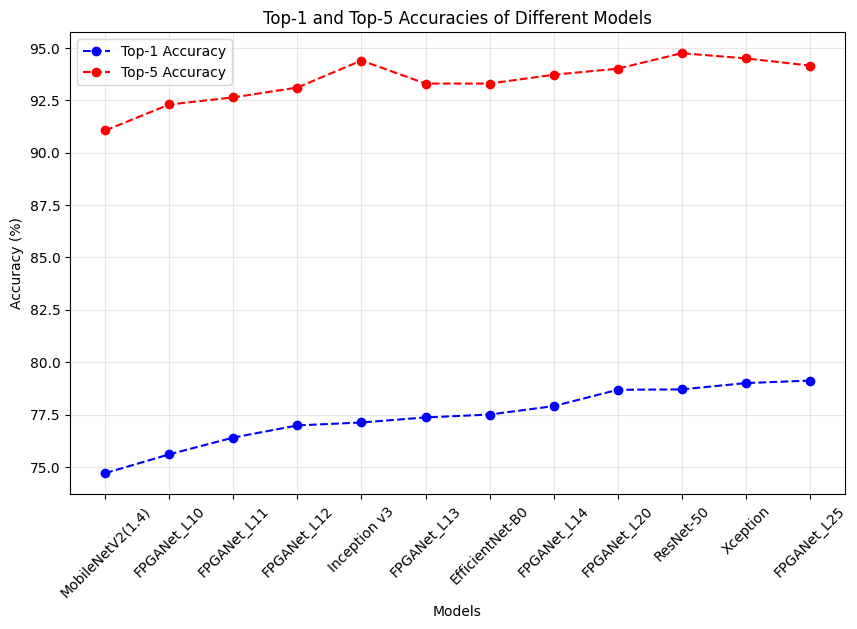

In [15]:
import matplotlib.pyplot as plt

# models and their accuracies
models = ["FPGANet_L10", "FPGANet_L11", "FPGANet_L12", "FPGANet_L13", "FPGANet_L15", "FPGANet_L20", "FPGANet_L25"]
top1_accuracies = [75.6, 76.4, 76.98, 77.36, 77.9, 78.68, 79.12]
top5_accuracies = [92.3, 92.64, 93.11, 93.3, 93.72, 94.01, 94.16]

#models and their accuracies
other_models = ['Xception', 'ResNet-50', 'EfficientNet-B0', 'MobileNetV2(1.4)', 'Inception v3']
other_top1_accuracies = [79, 78.7, 77.5, 74.7, 77.12]
other_top5_accuracies = [94.5, 94.75, 93.3, 91.06, 94.4]

# Combine models and other models
all_models = your_models + other_models
all_top1_accuracies = your_top1_accuracies + other_top1_accuracies
all_top5_accuracies = your_top5_accuracies + other_top5_accuracies

# Create a list of tuples, each containing the model name and its accuracies
data = list(zip(all_models, all_top1_accuracies, all_top5_accuracies))

# Sort the data by Top-1 accuracy
data.sort(key=lambda x: x[1])


models, top1_accuracies, top5_accuracies = zip(*data)

plt.figure(figsize=(10, 6))


plt.plot(models, top1_accuracies, marker='o', color='blue', linewidth=1.5, linestyle='--', label='Top-1 Accuracy')

plt.plot(models, top5_accuracies, marker='o', color='red', linewidth=1.5, linestyle='--', label='Top-5 Accuracy')

plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Top-1 and Top-5 Accuracies of Different Models')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


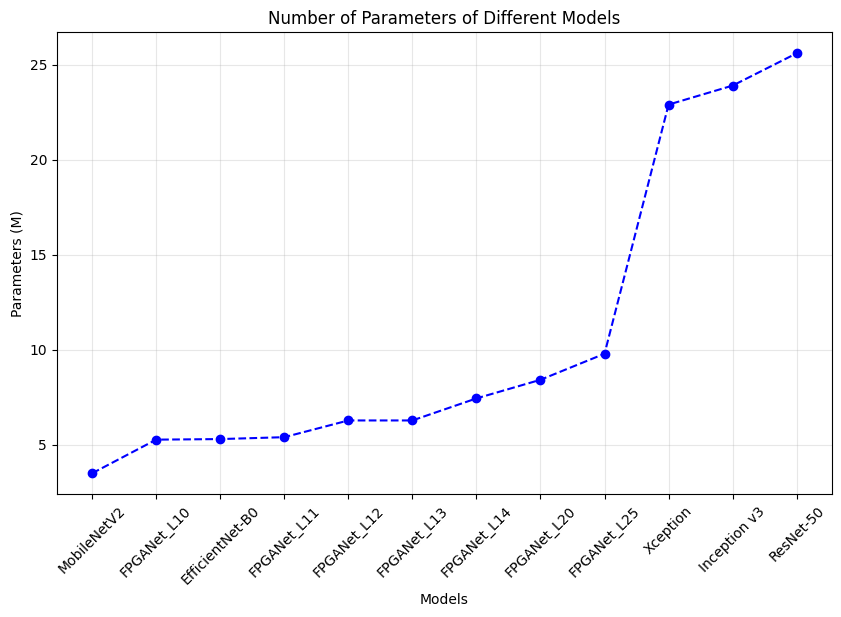

In [16]:
import matplotlib.pyplot as plt


models = ["FPGANet_L10", "FPGANet_L11", "FPGANet_L12", "FPGANet_L13", "FPGANet_L14", "FPGANet_L20", "FPGANet_L25"]
params = [5.27, 5.4, 6.28, 6.28, 7.44, 8.42, 9.79]

other_models = ['Xception', 'ResNet-50', 'EfficientNet-B0', 'MobileNetV2', 'Inception v3']
other_params = [22.9, 25.6, 5.3, 3.5, 23.9]

all_models = your_models + other_models
all_params = your_params + other_params

data = list(zip(all_models, all_params))

data.sort(key=lambda x: x[1])

models, params = zip(*data)

plt.figure(figsize=(10, 6))

plt.plot(models, params, marker='o', color='blue', linewidth=1.5, linestyle='--')

plt.xlabel('Models')
plt.ylabel('Parameters (M)')
plt.title('Number of Parameters of Different Models')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


In [12]:
!pip install adjustText

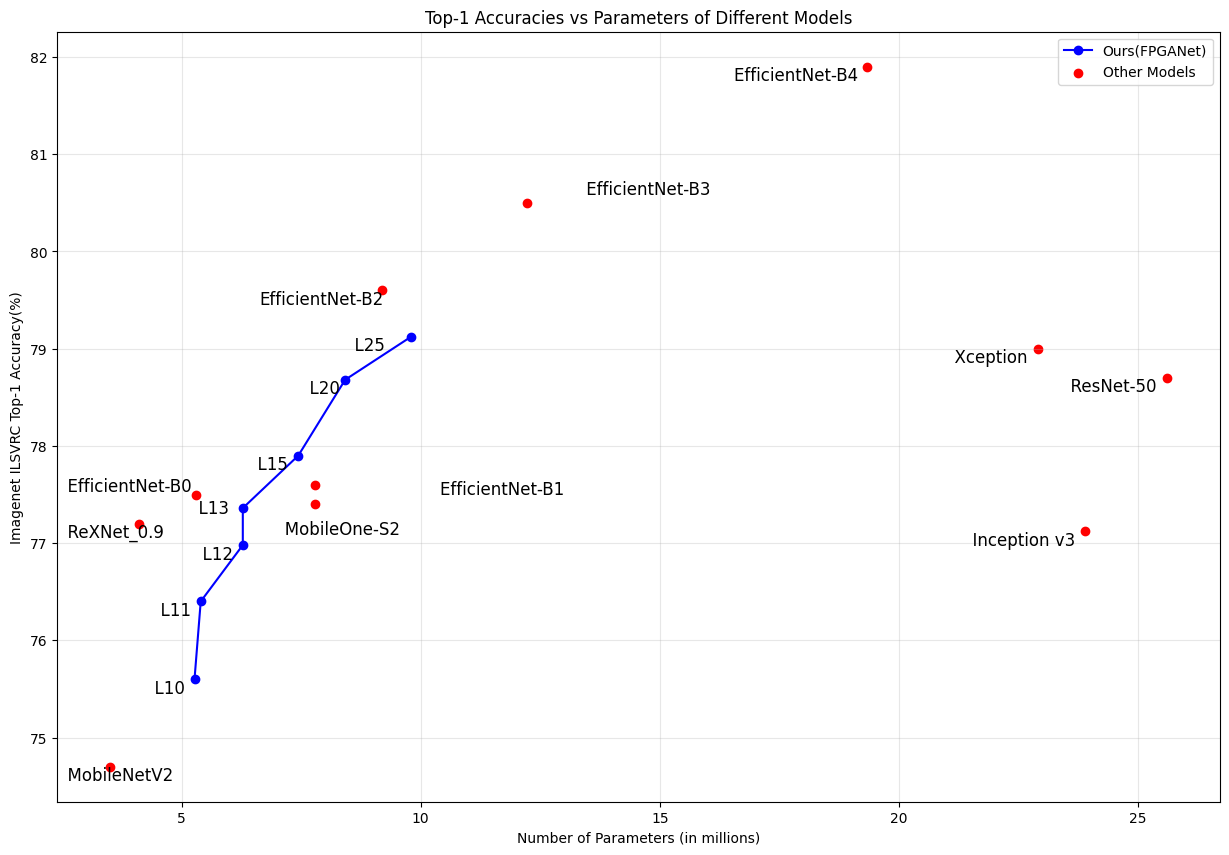

In [17]:
import matplotlib.pyplot as plt
from adjustText import adjust_text

# searched models and their accuracies
models = ["  L10  ", "  L11  ", "  L12  ", "  L13  ", "  L15  ", "  L20 ", "  L25     "]
top1_accuracies = [75.6, 76.4, 76.98, 77.36, 77.9, 78.68, 79.12]
params = [5.27, 5.4, 6.28, 6.28, 7.44, 8.42, 9.79]

# Other models and their accuracies
other_models = ["  Xception  ", "  ResNet-50  ", "  EfficientNet-B0    ", "  MobileNetV2  ", "  Inception v3  ",
          "        EfficientNet-B1       ", "EfficientNet-B2", " EfficientNet-B3  ", "EfficientNet-B4  ",
         "       MobileOne-S2  ","  ReXNet_0.9  "] 
other_top1_accuracies = [79, 78.7, 77.5, 74.7, 77.12,77.6,79.6,80.5,81.9,77.4,77.2]
other_params = [22.9, 25.6, 5.3, 3.5, 23.9, 7.8, 9.2, 12.23, 19.34,7.8,4.1]

plt.figure(figsize=(15, 10))  # Increase the size

plt.plot(params, top1_accuracies, marker='o', color='blue', linewidth=1.5, linestyle='-', label='Ours(FPGANet)')

plt.scatter(other_params, other_top1_accuracies, color='red', label='Other Models')

texts = []
for i, model in enumerate(models):
    texts.append(plt.text(params[i], top1_accuracies[i], model, fontsize=12))

for i, model in enumerate(other_models):
    texts.append(plt.text(other_params[i], other_top1_accuracies[i], model, fontsize=12))

adjust_text(texts)

plt.xlabel('Number of Parameters (in millions)')
plt.ylabel('Imagenet ILSVRC Top-1 Accuracy(%)')
plt.title('Top-1 Accuracies vs Parameters of Different Models')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


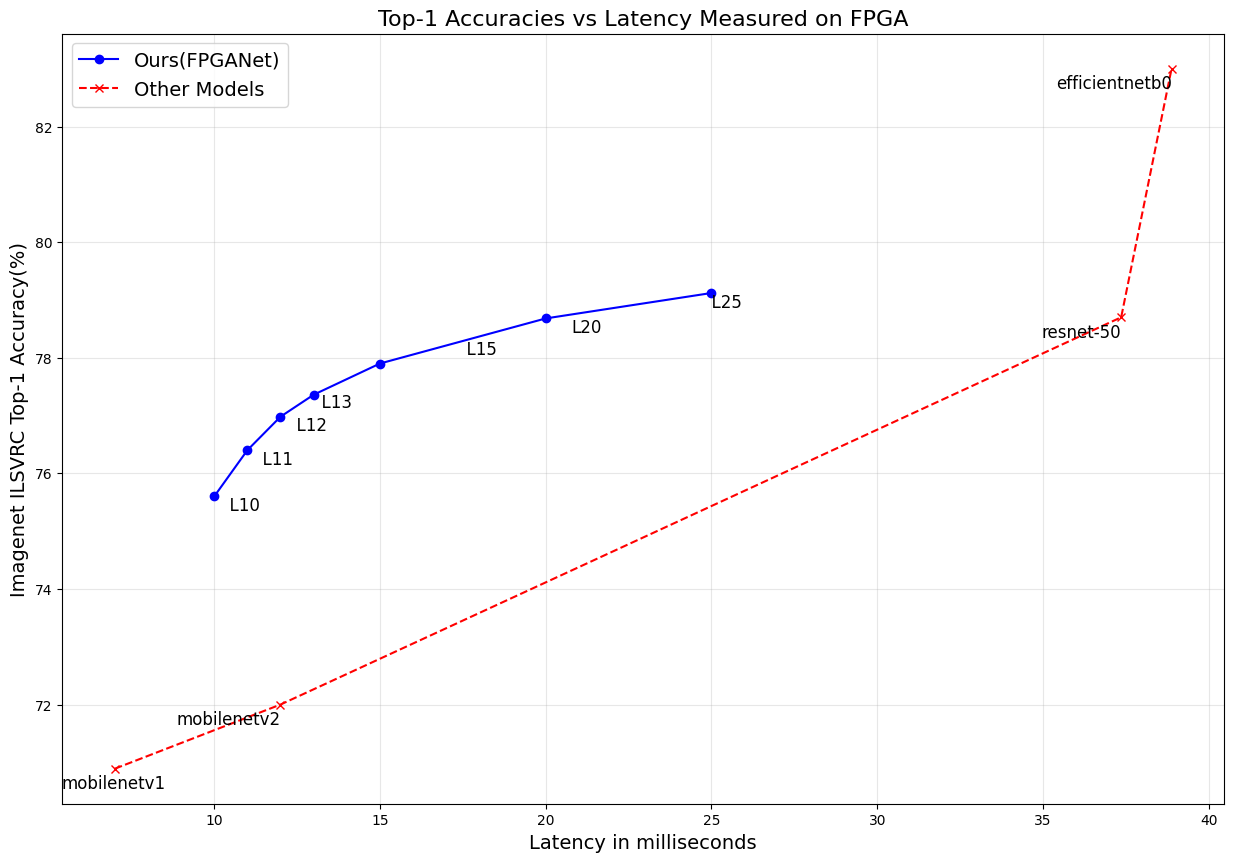

In [19]:
import matplotlib.pyplot as plt
from adjustText import adjust_text

models = ["  L10  ", "  L11  ", "  L12  ", "  L13  ", "  L15  ", "L20", "  L25     "]
top1_accuracies = [75.6, 76.4, 76.98, 77.36, 77.9, 78.68, 79.12]
latency=[10,11,12,13,15,20,25]


other_models = ["mobilenetv1","mobilenetv2","resnet-50","efficientnetb0"] 
other_top1_accuracies = [70.89,72.0,78.7,83]
other_latency = [7,12,37.36,38.88]

plt.figure(figsize=(15, 10))  # Increase the size

plt.plot(latency, top1_accuracies, marker='o', color='blue', linewidth=1.5, linestyle='-', label='Ours(FPGANet)')

plt.plot(other_latency, other_top1_accuracies,marker='x' ,color='red', linestyle='--', label='Other Models')

texts = []
for i, model in enumerate(models):
    texts.append(plt.text(latency[i]+1.7, top1_accuracies[i], model, fontsize=12))

for i, model in enumerate(other_models):
    texts.append(plt.text(other_latency[i], other_top1_accuracies[i]-0.1, model, fontsize=12))

adjust_text(texts)

plt.xlabel('Latency in milliseconds', fontsize=14)
plt.ylabel('Imagenet ILSVRC Top-1 Accuracy(%)', fontsize=14)
plt.title('Top-1 Accuracies vs Latency Measured on FPGA', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()


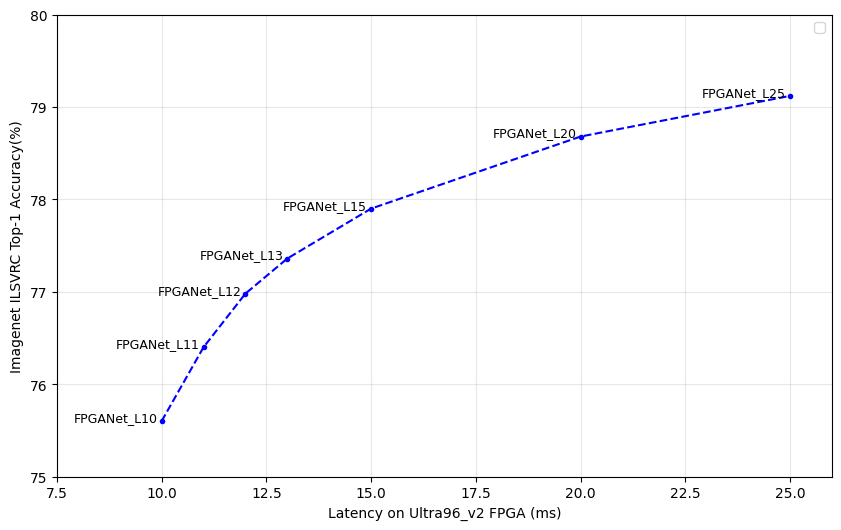

In [20]:
plt.figure(figsize=(10, 6))

latency = df['Latency (ms)']
accuracy = df['Top-1 Accuracy (%)']
models = df['Model']

plt.plot(latency, accuracy, marker = '.', color = 'blue', linewidth = '1.5', linestyle= '--')

for x,y,label in zip(latency, accuracy, models):
    plt.text(x-2.1, y, label, fontsize = 9, fontfamily='Times New Roman', color = 'black')

plt.xlabel('Latency on Ultra96_v2 FPGA (ms)')
plt.ylabel('Imagenet ILSVRC Top-1 Accuracy(%)')
plt.legend()
plt.ylim(75, 80)  # Limit y-axis from 76 to 80
plt.xlim(7.5, 26)   # Limit x-axis from 8 to 30
plt.grid(True, alpha=0.3)
plt.show()


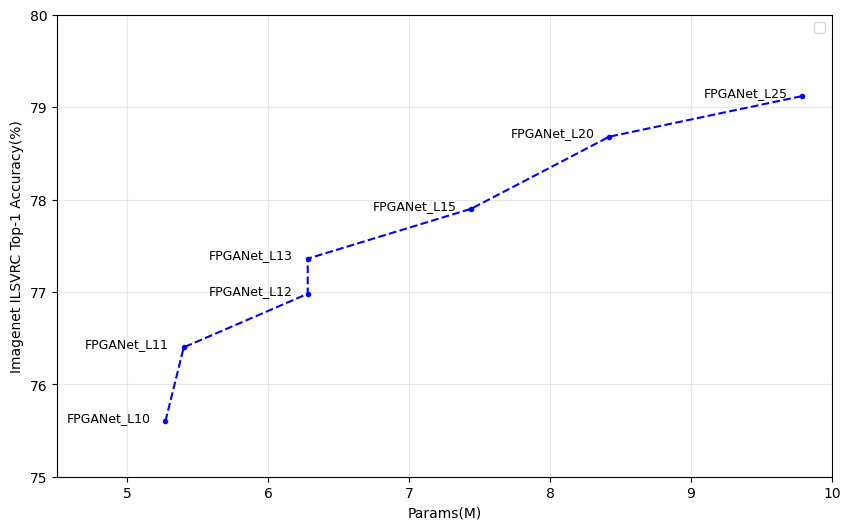

In [21]:
plt.figure(figsize=(10, 6))

p = df['Params (M)']
accuracy = df['Top-1 Accuracy (%)']
models = df['Model']

plt.plot(p, accuracy, marker = '.', color = 'blue', linewidth = '1.5', linestyle= '--')

for x,y,label in zip(p, accuracy, models):
    plt.text(x-0.7, y, label, fontsize = 9, fontfamily='Times New Roman')

plt.xlabel('Params(M)')
plt.ylabel('Imagenet ILSVRC Top-1 Accuracy(%)')
plt.legend()
plt.ylim(75, 80)  # Limit y-axis from 76 to 80
plt.xlim(4.5,10)
plt.grid(True, alpha=0.3)
plt.show()


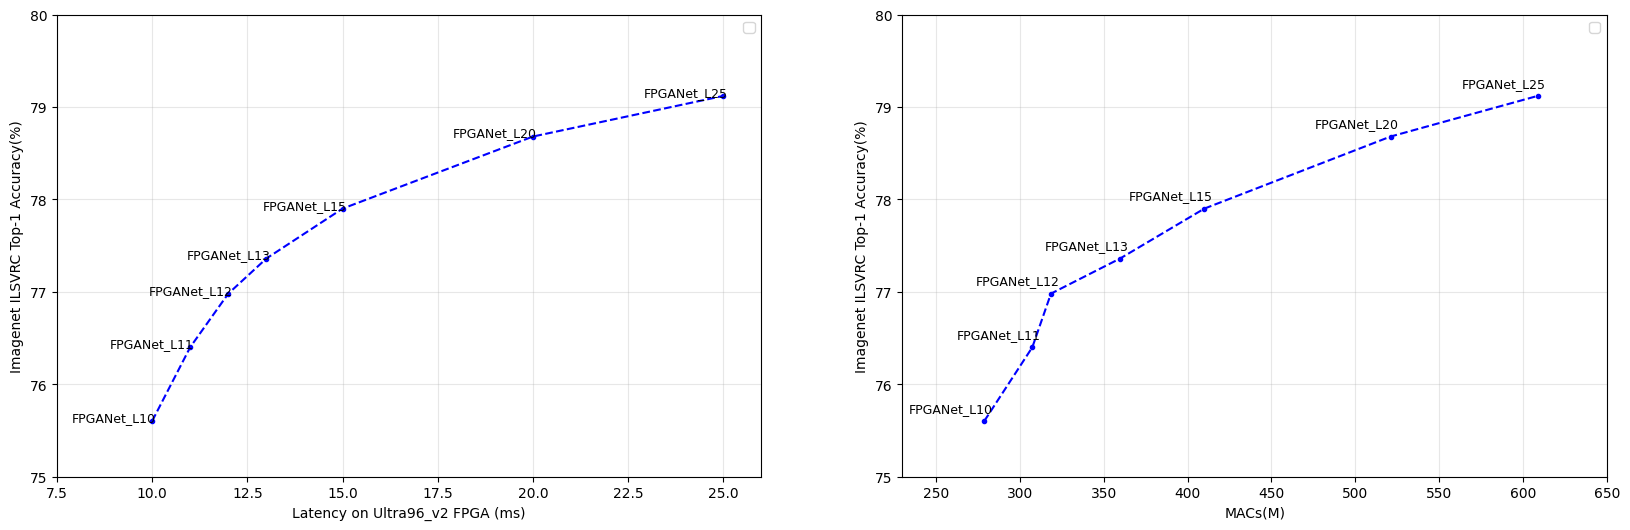

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
macs = df['MACs (M)']
# First subplot
axs[0].plot(latency, accuracy, marker = '.', color = 'blue', linewidth = '1.5', linestyle= '--')
for x,y,label in zip(latency, accuracy, models):
    axs[0].text(x-2.1, y, label, fontsize = 9, fontfamily='Times New Roman', color = 'black')
axs[0].set_xlabel('Latency on Ultra96_v2 FPGA (ms)')
axs[0].set_ylabel('Imagenet ILSVRC Top-1 Accuracy(%)')
axs[0].legend()
axs[0].set_ylim(75, 80)  # Limit y-axis from 76 to 80
axs[0].set_xlim(7.5, 26)   # Limit x-axis from 8 to 30
axs[0].grid(True, alpha=0.3)

# Second subplot
axs[1].plot(macs, accuracy, marker = '.', color = 'blue', linewidth = '1.5', linestyle= '--')
for x,y,label in zip(macs, accuracy, models):
    axs[1].text(x-45, y+0.1, label, fontsize = 9, fontfamily='Times New Roman')
axs[1].set_xlabel('MACs(M)')
axs[1].set_ylabel('Imagenet ILSVRC Top-1 Accuracy(%)')
axs[1].legend()
axs[1].set_ylim(75, 80)  # Limit y-axis from 76 to 80
axs[1].set_xlim(230,650)
axs[1].grid(True, alpha=0.3)

plt.show()


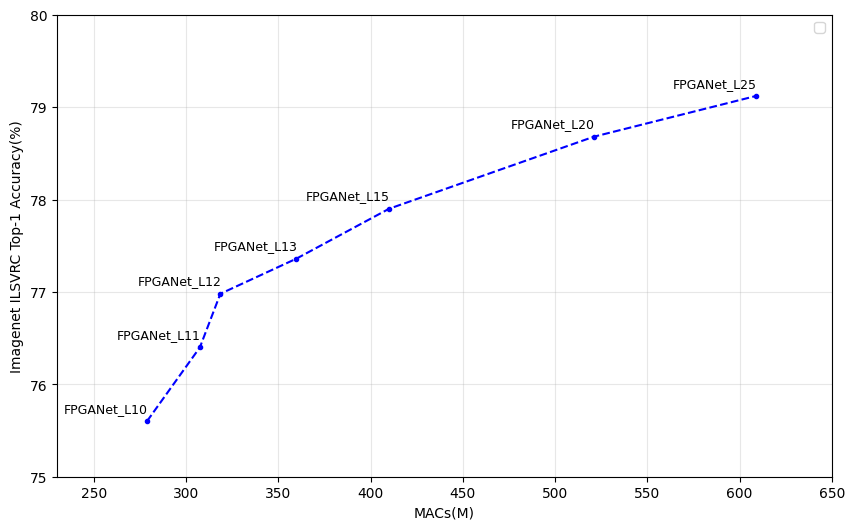

In [23]:
plt.figure(figsize=(10, 6))

m = df['MACs (M)']
accuracy = df['Top-1 Accuracy (%)']
models = df['Model']

plt.plot(m, accuracy, marker = '.', color = 'blue', linewidth = '1.5', linestyle= '--')

for x,y,label in zip(m, accuracy, models):
    plt.text(x-45, y+0.1, label, fontsize = 9, fontfamily='Times New Roman')

plt.xlabel('MACs(M)')
plt.ylabel('Imagenet ILSVRC Top-1 Accuracy(%)')
plt.legend()
plt.ylim(75, 80)  # Limit y-axis from 76 to 80
plt.xlim(230,650)
plt.grid(True, alpha=0.3)
plt.show()


In [ ]:
model = models['11']
device = torch.device("cuda")
model.to(device)
dummy_input = torch.randn(1, 3,224,224, dtype=torch.float).to(device)

# INIT LOGGERS
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
repetitions = 300
timings=np.zeros((repetitions,1))
#GPU-WARM-UP
for _ in range(10):
    _ = model(dummy_input)
# MEASURE PERFORMANCE
with torch.no_grad():
    for rep in range(repetitions):
        starter.record()
        _ = model(dummy_input)
        ender.record()
        # WAIT FOR GPU SYNC
        torch.cuda.synchronize()
        curr_time = starter.elapsed_time(ender)
        timings[rep] = curr_time

mean_syn = np.sum(timings) / repetitions
std_syn = np.std(timings)
print(mean_syn)
